# **Regresión Dinámica Inversa para doble péndulo**

In [2]:
import math
import numpy as np
import tensorflow as tf
import keras 
import pandas as pd
import json
import os
#from tensorflow import keras
from keras.models import Sequential #One of the most important classes in tensorflow, used to creare NN (Named after NN as a sequence of layers)
from keras.layers import Input, Dense, LSTM, BatchNormalization, Dropout #Dense layer means that one neuron in one layer is connected to all neurons in the next layer
from keras.regularizers import l2, l1, l1_l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow.keras.backend as K

In [3]:
datos_2LRP_random = pd.read_csv(f'./2lpr_randomsamples_2025_05_13-23_28_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
datos_2LRP_joint = pd.read_csv(f'./2lpr_jointmovement_2025_05_03-19_10_52.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
#datos_2LRP_joint = pd.read_csv(f'./2lpr_jointmovement_2025_05_21-13_16_02.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
datos_2LRP_cart = pd.read_csv(f'./2lpr_cartesianmovement_2025_05_05-22_50_57.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

In [4]:
pos_j1 = datos_2LRP_random.iloc[:,1].values
pos_j2 = datos_2LRP_random.iloc[:,2].values

vels_j1 = datos_2LRP_random.iloc[:,3].values
vels_j2 = datos_2LRP_random.iloc[:,4].values

accs_j1 = datos_2LRP_random.iloc[:,5].values
accs_j2 = datos_2LRP_random.iloc[:,6].values

torq_j1 = datos_2LRP_random.iloc[:,7].values
torq_j2 = datos_2LRP_random.iloc[:,8].values

In [5]:
time_joint = datos_2LRP_joint.iloc[:,1].values

pos_j1_joint = datos_2LRP_joint.iloc[:,2].values
pos_j2_joint = datos_2LRP_joint.iloc[:,3].values

vels_j1_joint = datos_2LRP_joint.iloc[:,4].values
vels_j2_joint = datos_2LRP_joint.iloc[:,5].values

accs_j1_joint = datos_2LRP_joint.iloc[:,6].values
accs_j2_joint = datos_2LRP_joint.iloc[:,7].values

torq_j1_joint = datos_2LRP_joint.iloc[:,8].values
torq_j2_joint = datos_2LRP_joint.iloc[:,9].values

In [6]:
time_cart = datos_2LRP_cart.iloc[:,1].values

pos_j1_cart = datos_2LRP_cart.iloc[:,2].values
pos_j2_cart = datos_2LRP_cart.iloc[:,3].values

vels_j1_cart = datos_2LRP_cart.iloc[:,4].values
vels_j2_cart = datos_2LRP_cart.iloc[:,5].values

accs_j1_cart = datos_2LRP_cart.iloc[:,6].values
accs_j2_cart = datos_2LRP_cart.iloc[:,7].values

torq_j1_cart = datos_2LRP_cart.iloc[:,8].values
torq_j2_cart = datos_2LRP_cart.iloc[:,9].values

# **Red neuronal Secuencial (Same-step approach)**:

No es el entrenamiento de las redes lo que se compara, sino la calidad de los resultados finales. Cada red tiene una técnica de entrenamiento: las secuenciales no aprenden la correlación entre muestras, entonces es mejor entrenarlas con muestras descorrelacionadas -> ruido blanco, en cambio, las redes LSTM aprenden la historia y evolución del sistema (la correlación entre muestras), van a necesitar muestras ordenadas, secuencia de tiempo.

Problema Dinámico INVERSO: Dados las posiciones, velocidades y aceleraciones joint, obtener el valor de los torques necesarios para mantener esa posición.

En el método de same step approach, tengo que tener en cuenta cómo se describe la fórmula a analizar. Para el problema inverso, tengo en cuenta que la expresión de la dinámica es una función contínua, pero todo refiere al mismo instante de tiempo, ya que dadas las posiciones, velocidades y aceleraciones, el valor de torque obtenido es aquel para mantener esta posición. Entonces los valores de posición y velocidad son para el instante de tiempo del torque resultante. 

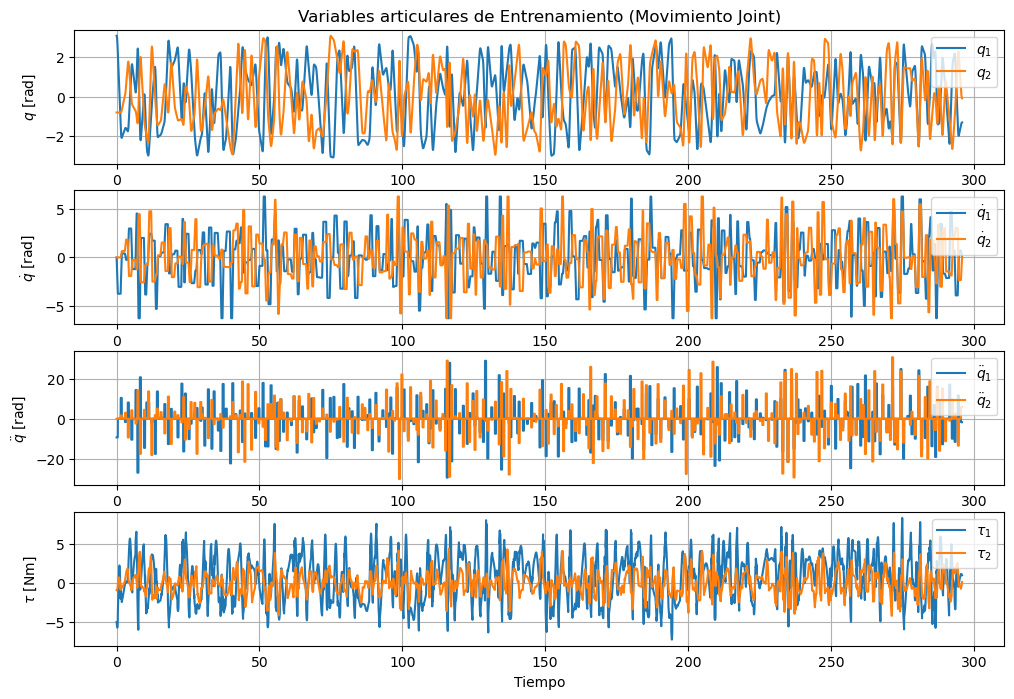

In [7]:
num_links = 2

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades
plt.subplot(4,1,1)
plt.plot(time_joint, pos_j1_joint)
plt.plot(time_joint, pos_j2_joint)
plt.legend([r'$q_1$', r'$q_2$'],loc='upper right', fontsize=10);  plt.ylabel(r"$q$ [rad]")
plt.grid(True)
plt.title('Variables articulares de Entrenamiento (Movimiento Joint)')
plt.subplot(4,1,2)
plt.plot(time_joint, vels_j1_joint)
plt.plot(time_joint, vels_j2_joint)
plt.legend([r'$\dot{q}_1$', r'$\dot{q}_2$'],loc='upper right', fontsize=10);  plt.ylabel(r"$\dot{q}$ [rad]")
plt.grid(True)
plt.subplot(4,1,3)
plt.plot(time_joint, accs_j1_joint)
plt.plot(time_joint, accs_j2_joint)
plt.legend([r'$\ddot{q}_1$', r'$\ddot{q}_2$'],loc='upper right', fontsize=10);  plt.ylabel(r"$\ddot{q}$ [rad]")
plt.grid(True)
plt.subplot(4,1,4)
plt.plot(time_joint, torq_j1_joint)
plt.plot(time_joint, torq_j2_joint)
plt.legend([r'$\tau_{1}$', r'$\tau_{2}$'],loc='upper right', fontsize=10); plt.xlabel('Tiempo'); plt.ylabel(r"$\tau$ [Nm]")
plt.grid(True)
plt.show()

In [8]:
#inputs = np.vstack((pos_j1, pos_j2, vels_j1, vels_j2, accs_j1, accs_j2)).T
#outputs = np.vstack((torq_j1, torq_j2)).T
inputs = np.vstack((pos_j1_joint, pos_j2_joint, vels_j1_joint, vels_j2_joint, accs_j1_joint, accs_j2_joint)).T
outputs = np.vstack((torq_j1_joint, torq_j2_joint)).T

In [9]:
inputs.shape

(295903, 6)

In [10]:
# Defino el conjunto de datos que voy a usar para entrenar y el que voy a usar para validar (test) -> Porcentajes similares al usados en el paper
X_train_SS, X_test_SS, y_train_SS, y_test_SS = train_test_split(inputs, outputs, test_size = 0.15)
X_train_SS, X_val_SS, y_train_SS, y_val_SS = train_test_split(X_train_SS, y_train_SS, test_size=0.15)

In [11]:
X_train_SS.shape

(213789, 6)

In [12]:
X_test_SS.shape

(44386, 6)

In [13]:
#X_val_SS.shape

In [14]:
#Tengo que hacer preprocesado de los datos para que los calculos no sean tan pesados
scaler1_FF = StandardScaler() #StandardScaler()#
X_train_SS = scaler1_FF.fit_transform(X_train_SS)#Primero se llama a la funcion fit para que ajuste los datos
X_test_SS = scaler1_FF.transform(X_test_SS) #Una vez que los datos fueron ajustados se puede llamar a la transformacion directamente
X_val_SS = scaler1_FF.transform(X_val_SS)

#Lo mismo para los outputs
scaler2_FF = StandardScaler() #StandardScaler()#
y_train_SS = scaler2_FF.fit_transform(y_train_SS)
y_test_SS = scaler2_FF.transform(y_test_SS)
y_val_SS = scaler2_FF.transform(y_val_SS)

🔄 Cargando modelo FF NN existente...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,008 (128.94 KB)

 Trainable params: 11,002 (42.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,006 (85.96 KB)

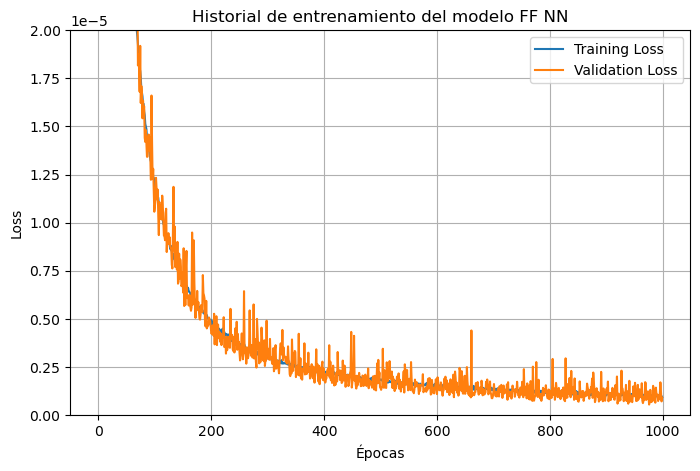

✅ Modelo FF NN listo para usar.


In [15]:
# Verificar si el modelo ya existe

FF_NN_model_path = "./2LPR/ID_NN/Modelos_NN/FF_NN/ff_nn_SS_Best_Model.keras"
FF_NN_history_path = "./2LPR/ID_NN/Modelos_NN/FF_NN/ff_nn_best_history.json"

if os.path.exists(FF_NN_model_path):
    print("🔄 Cargando modelo FF NN existente...")
    FF_SS_network = keras.models.load_model(FF_NN_model_path)
    FF_SS_network.summary()

    if os.path.exists(FF_NN_history_path):
        with open(FF_NN_history_path, "r") as f:
            FF_NN_history = json.load(f)  # Load the history data as a dictionary

        # Create a dummy History object for plotting:
        #FF_NN_history = type('DummyHistory', (object,), {'history': FF_NN_history_dict})()

        # Graficar el history
        plt.figure(figsize=(8, 5))
        plt.plot(FF_NN_history["loss"], label="Training Loss")
        plt.plot(FF_NN_history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.gca().set_ylim(0, 2e-5)
        plt.title("Historial de entrenamiento del modelo FF NN")
        plt.show()
    else:
        print("⚠️ No se encontró el archivo de history.")
else:
    print("⚙️ Creando nuevo modelo...")
    #Esta forma es lo más parecida posible al paper
    FF_SS_network = keras.models.Sequential([
        keras.layers.Dense(100, activation="gelu", input_shape=(inputs.shape[1],)),
        #keras.layers.Dropout(0.1),
        keras.layers.Dense(100, activation="gelu"),
        #keras.layers.Dense(20, activation="tanh"),
        #keras.layers.Dense(10, activation="tanh"),
        keras.layers.Dense(2)
    ])
    FF_SS_network.summary()

    FF_SS_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
                          metrics = ['mae'])#Que pasa si uso SGD con learning rate


    checkpoint_cb = keras.callbacks.ModelCheckpoint(FF_NN_model_path, 
                                                    save_best_only=True)
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=200, min_delta=1e-10, restore_best_weights=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor=['loss', 'val_loss'], factor=0.5, patience=10, min_lr=1e-8)
    
    FF_NN_history = FF_SS_network.fit(X_train_SS, y_train_SS, epochs=1000, 
                                      batch_size=200, validation_data=(X_val_SS, y_val_SS),
                                      callbacks=[checkpoint_cb, early_stopping_cb])

    with open(FF_NN_history_path, "w") as f:
        json.dump(FF_NN_history.history, f)
    with open(FF_NN_history_path, "r") as f:
        FF_NN_history = json.load(f)  # Load the history data as a dictionary

    # Create a dummy History object for plotting:
    #FF_NN_history = type('DummyHistory', (object,), {'history': FF_NN_history_dict})()

    pd.DataFrame(FF_NN_history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 2e-5)
    plt.show()

print("✅ Modelo FF NN listo para usar.")

In [16]:
accuracy_test_NN = FF_SS_network.evaluate(X_test_SS, y_test_SS)

1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0754e-05 - mae: 0.0026


In [17]:
predictions_NN = FF_SS_network.predict(X_test_SS)

1388/1388 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step


In [18]:
predictions_NN[0]

array([-0.12441342, -0.3441351 ], dtype=float32)

In [19]:
y_test_SS[0]

array([-0.11885478, -0.34180181])

# **Red neuronal Secuencial (One-step-ahead approach)**

¿Es válido hacer un análisis One Step Ahead si el problema dinámico inverso se plantea como dadas las posiciones, velocidades y aceleraciones joint, obtener el valor de los torques necesarios para mantener esa posición?

Para el análisis con los datos randomizados, no tengo una secuencialidad de los datos ya que cada muestra es randomizada. Voy a probarlo con otro conjunto de muestras, pero inicialmente, creería que para resolver el problema dinámico no tiene sentido utilizar este método.

# **Red neuronal LSTM**

En primer lugar, voy a probar el entrenamiento con movimiento joint

In [20]:
def create_lstm_sequences(inputs, outputs, time_joint, window_size=50, split=0.8):
    """
    Genera secuencias de entrada y salida para una LSTM a partir de los datos de posición, velocidad, aceleración y torque.
    
    Args:
        inputs: Matriz de entrada que contiene las posiciones, velocidades y aceleraciones.
        outputs: Matriz de salida que contiene los torques.
        time_joint: Vector de tiempo asociado a los datos.
        window_size: Tamaño de la ventana de tiempo para la LSTM.
        split: Proporción del dataset que se utiliza para entrenamiento (el resto para prueba).
        
    Returns:
        X_train: Secuencias de entrada para entrenamiento.
        Y_train: Secuencias de salida para entrenamiento.
        X_test: Secuencias de entrada para prueba.
        Y_test: Secuencias de salida para prueba.
        t_test: Vector de tiempo correspondiente al conjunto de prueba.
    """
    # Preparar las secuencias de entrada y salida usando ventanas deslizantes
    input_sequences = []
    output_sequences = []
    
    for i in range(len(inputs) - window_size):
        input_sequences.append(inputs[i:i+window_size])
        output_sequences.append(outputs[i+window_size])
    
    # Convertir a arrays numpy
    X = np.array(input_sequences)
    Y = np.array(output_sequences)
    
    # Dividir en conjuntos de entrenamiento y prueba
    if split > 0 and split < 1:
        idx_split = int(split * len(X))
        X_train, X_test = X[:idx_split], X[idx_split:]
        Y_train, Y_test = Y[:idx_split], Y[idx_split:]
        t_test = time_joint[idx_split:len(inputs) - window_size]
    else:
        X_train, X_test = X, None
        Y_train, Y_test = Y, None
        t_test = time_joint[:len(inputs) - window_size]
    
    return X_train, Y_train, X_test, Y_test, t_test


In [21]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time_joint = datos_2LRP_joint.iloc[:,1].values  

pos_j1_joint = datos_2LRP_joint.iloc[:,2].values
pos_j2_joint = datos_2LRP_joint.iloc[:,3].values

vels_j1_joint = datos_2LRP_joint.iloc[:,4].values
vels_j2_joint = datos_2LRP_joint.iloc[:,5].values

accs_j1_joint = datos_2LRP_joint.iloc[:,6].values
accs_j2_joint = datos_2LRP_joint.iloc[:,7].values

torq_j1_joint = datos_2LRP_joint.iloc[:,8].values
torq_j2_joint = datos_2LRP_joint.iloc[:,9].values

In [22]:
inputs_joint = np.vstack((pos_j1_joint, pos_j2_joint, vels_j1_joint, vels_j2_joint, accs_j1_joint, accs_j2_joint)).T
outputs_joint = np.vstack((torq_j1_joint, torq_j2_joint)).T

In [23]:
#Para las LSTM es necesario que defin
# N_segments = 50 #Puntos destino de movimiento joint

# Definir el tamaño de la ventana de tiempo para las secuencias
w_size = 2

# Preprocesar (escalar) los inputs y outputs antes de crear las secuencias
scaler1_LSTM = StandardScaler() #StandardScaler()
inputs_joint = scaler1_LSTM.fit_transform(inputs_joint)

scaler2_LSTM = StandardScaler() #StandardScaler()
outputs_joint = scaler2_LSTM.fit_transform(outputs_joint)

X_train_LSTM, y_train_LSTM, X_test_LSTM, y_test_LSTM, t_test_LSTM  = create_lstm_sequences(inputs_joint, outputs_joint, time_joint, window_size=w_size, split=0.8)

In [24]:
print(X_train_LSTM.shape)  # Verifica el tamaño de las muestras
print(y_train_LSTM.shape)  # Verifica el tamaño de las etiquetas


(236720, 2, 6)
(236720, 2)


🔄 Cargando modelo LSTM existente...


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 20)             │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,608 (25.82 KB)

 Trainable params: 2,202 (8.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,406 (17.21 KB)

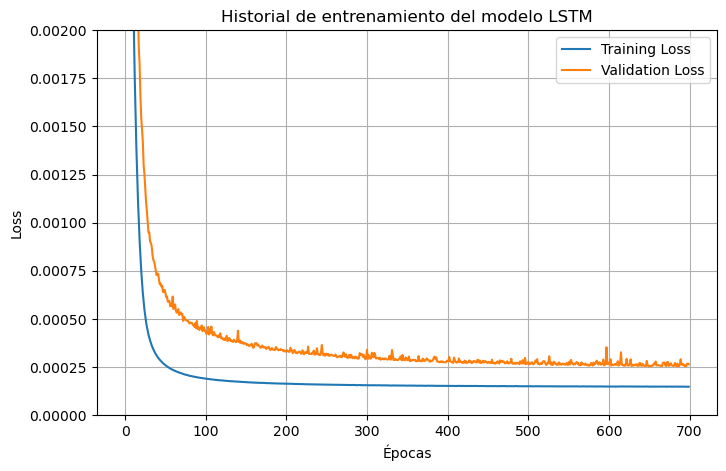

✅ Modelo LSTM listo para usar.


In [25]:
# Verificar si el modelo ya existe

LSTM_model_path = "./2LPR/ID_NN/Modelos_NN/LSTM/LSTM_nn_Best_Model.keras"
LSTM_history_path = "./2LPR/ID_NN/Modelos_NN/LSTM/lstm_best_history.json"

if os.path.exists(LSTM_model_path):
    print("🔄 Cargando modelo LSTM existente...")
    LSTM_network = keras.models.load_model(LSTM_model_path)
    LSTM_network.summary()

    if os.path.exists(LSTM_history_path):

        with open(LSTM_history_path, "r") as f:
            LSTM_history = json.load(f)  # Load the history data as a dictionary
        # Create a dummy History object for plotting:
        #LSTM_history = type('DummyHistory', (object,), {'history': LSTM_history_dict})()

        # Graficar el history
        plt.figure(figsize=(8, 5))
        plt.plot(LSTM_history["loss"], label="Training Loss")
        plt.plot(LSTM_history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.gca().set_ylim(0, 2e-3)
        plt.title("Historial de entrenamiento del modelo LSTM")
        plt.show()
    else:
        print("⚠️ No se encontró el archivo de history.")
else:
    print("⚙️ Creando nuevo modelo...")
    LSTM_network = Sequential() #Sequential([Input(shape=(w_size, X_train_LSTM.shape[2]))])
    LSTM_network.add(LSTM(20, activation='gelu', input_shape=(w_size, X_train_LSTM.shape[2])))
    
    #LSTM_network.add(LSTM(20, activation='tanh', input_shape=(w_size, X_train_LSTM.shape[2]), 
    #                return_sequences=True))
    #LSTM_network.add(LSTM(2, activation='tanh',
    #                return_sequences=True, kernel_regularizer=l2(0)))
    #LSTM_network.add(LSTM(10, activation='tanh'))
    LSTM_network.add(Dense(y_train_LSTM.shape[1]))
    LSTM_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(1e-4), metrics = ['mae']) #learning_rate=1e-5
    #mean_sqared_error
    LSTM_network.summary()


    #LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CT_p/Modelos_NN/LINEAR/LSTM_nn_Best_Model.h5", save_best_only=True)
    LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint(LSTM_model_path,save_best_only=True)
    LSTM_early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                           patience=100, min_delta=1E-10, 
                                                           restore_best_weights=True)

    LSTM_history = LSTM_network.fit(X_train_LSTM, y_train_LSTM, epochs=700, 
                                    batch_size=64, validation_split=0.2, 
                                    callbacks=[LSTM_checkpoint_cb, LSTM_early_stopping_cb])
    
    with open(LSTM_history_path, "w") as f:
        json.dump(LSTM_history.history, f)
    with open(LSTM_history_path, "r") as f:
        LSTM_history = json.load(f)  # Load the history data as a dictionary

    # Create a dummy History object for plotting:
    #LSTM_history = type('DummyHistory', (object,), {'history': LSTM_history_dict})()

    pd.DataFrame(LSTM_history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 2e-3)
    plt.show()

print("✅ Modelo LSTM listo para usar.")

In [26]:
LSTM_accuracy_test = LSTM_network.evaluate(X_test_LSTM, y_test_LSTM)

1850/1850 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2.2213e-04 - mae: 0.0049


In [27]:
predictions_LSTM = LSTM_network.predict(X_test_LSTM)

1850/1850 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [28]:
predictions_LSTM[0]

array([1.7283989, 2.76337  ], dtype=float32)

In [29]:
y_test_LSTM[0]

array([1.72148976, 2.76203873])

# **Comparación de Modelos NN con otro conjunto de datos**

La comparación de los modelos 

In [30]:
#Uso el otro dataset joint

datos_2LRP_ref_joint = pd.read_csv(f'./2lpr_jointmovement_2024-10-03.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
#datos_2LRP_ref_joint.head()
t_ref = datos_2LRP_ref_joint.iloc[:,1].values

q1_ref = datos_2LRP_ref_joint.iloc[:,2].values
q2_ref = datos_2LRP_ref_joint.iloc[:,3].values

dq1_ref = datos_2LRP_ref_joint.iloc[:,4].values
dq2_ref = datos_2LRP_ref_joint.iloc[:,5].values

ddq1_ref = datos_2LRP_ref_joint.iloc[:,6].values
ddq2_ref = datos_2LRP_ref_joint.iloc[:,7].values

t1_ref = datos_2LRP_ref_joint.iloc[:,8].values
t2_ref = datos_2LRP_ref_joint.iloc[:,9].values
datos_2LRP_ref_joint.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.926178,-1.430799,0.001258,0.004265,1.257762,4.265447,-2.000074,-0.890958
1,2,0.001,-1.926176,-1.430793,0.002516,0.008531,1.257762,4.265447,-1.999438,-0.888827
2,3,0.002,-1.926173,-1.430782,0.003773,0.012796,1.257762,4.265447,-1.998798,-0.886697
3,4,0.003,-1.926168,-1.430767,0.005031,0.017062,1.257762,4.265447,-1.998153,-0.884568
4,5,0.004,-1.926163,-1.430748,0.006289,0.021327,1.257762,4.265447,-1.997503,-0.882441


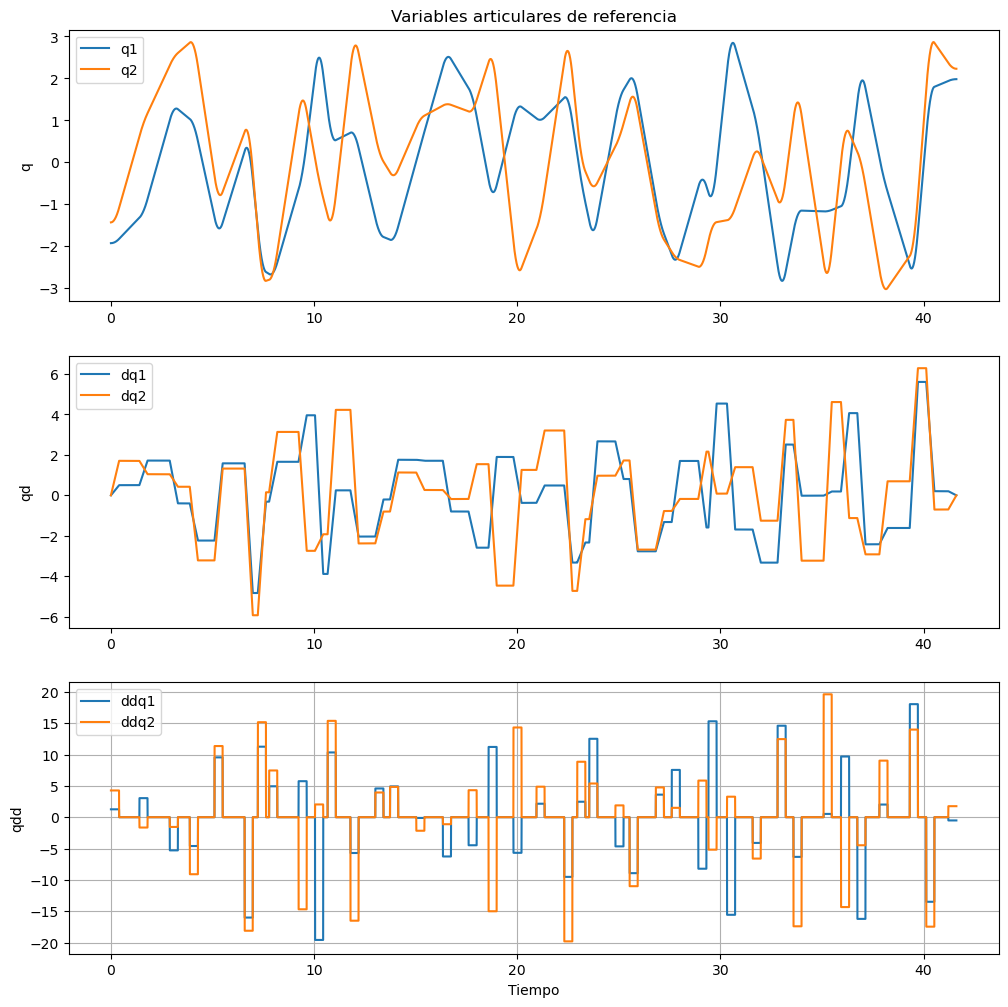

In [31]:
num_links = 2

plt.figure(figsize=(12, 12))
plt.subplot(3,1,1)
plt.plot(t_ref, q1_ref, label='q1')
plt.plot(t_ref, q2_ref, label='q2')
plt.legend();  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref, dq1_ref, label='dq1')
plt.plot(t_ref, dq2_ref, label='dq2')
plt.legend();  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref, ddq1_ref, label='ddq1')
plt.plot(t_ref, ddq2_ref, label='ddq2')
plt.legend(); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.grid(True)
plt.show()


In [32]:
inputs_ref = np.vstack((q1_ref,q2_ref,dq1_ref,dq2_ref,ddq1_ref,ddq2_ref)).T
outputs_ref = np.vstack((t1_ref,t2_ref)).T

In [33]:
#Primero con FF NN

X_test_scaled_FF_NN = scaler1_FF.transform(inputs_ref)
tau_sim_FF_NN = scaler2_FF.inverse_transform(FF_SS_network.predict(X_test_scaled_FF_NN))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [34]:
#Ahora con LSTM

def create_sequences_with_time(data, time, window_size= w_size):
    sequences = []
    times = []
    
    for i in range(len(data) - window_size + 1):
        sequence = data[i:i + window_size]
        sequences.append(sequence)
        
        # Obtener el tiempo correspondiente al centro de la ventana
        time_center = time[i + window_size // 2]  # Usa el centro de la ventana
        times.append(time_center)
    
    return np.array(sequences), np.array(times)

X_test_scaled_LSTM = scaler1_LSTM.transform(inputs_ref)
X_test_windowed_LSTM, t_ref_LSTM = create_sequences_with_time(X_test_scaled_LSTM, t_ref)
tau_sim_LSTM = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


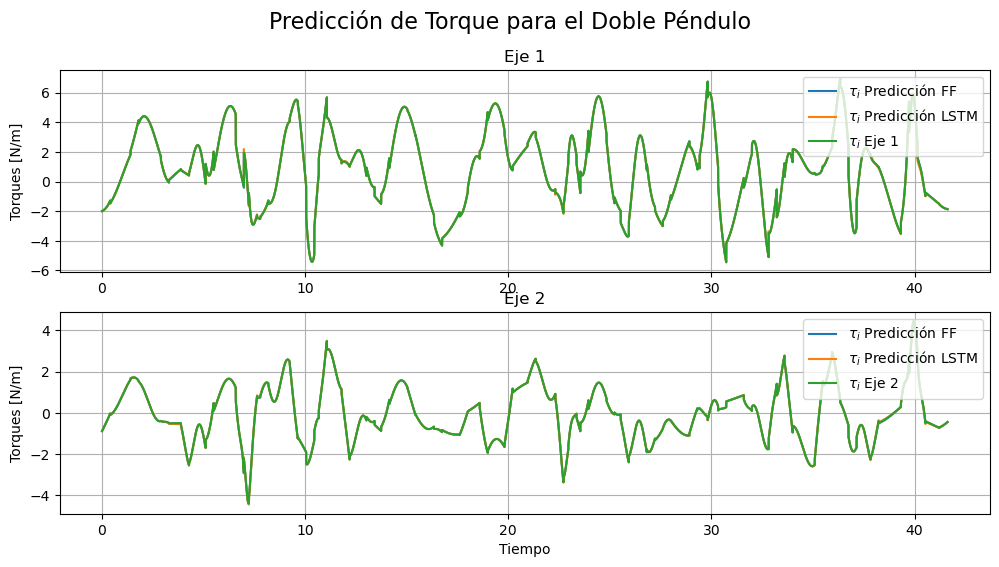

In [35]:
plt.figure(figsize=(12, 6)) 

# Agregar un título general
plt.suptitle("Predicción de Torque para el Doble Péndulo", fontsize=16, y=0.95)

# Grafico los resultados
for i in range(num_links):
  plt.subplot(num_links, 1, i+1)
  plt.plot(t_ref,tau_sim_FF_NN[:,i])
  plt.plot(t_ref_LSTM,tau_sim_LSTM[:,i])
  plt.plot(t_ref,outputs_ref[:,i])
  plt.legend([r"$\tau_{i}$ Predicción FF", r"$\tau_{i}$ Predicción LSTM", r"$\tau_{i}$ " f'Eje {i+1}'],loc='upper right', fontsize=10)
  plt.ylabel('Torques [N/m]')
  plt.title(f'Eje {i+1}', fontsize=12)
  plt.grid(True)

plt.subplots_adjust(top=0.85)  
plt.xlabel('Tiempo');
plt.show()

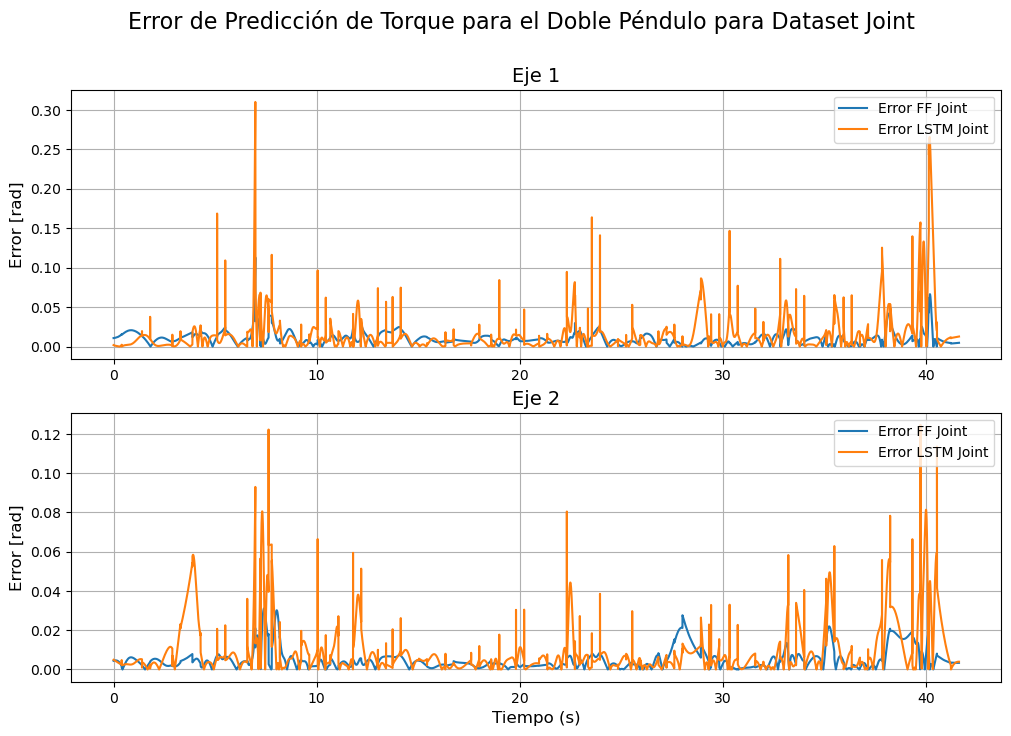

In [36]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Torque para el Doble Péndulo para Dataset Joint", fontsize=16,  y=0.95)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)

    error_SS_Joint_j = np.sqrt((tau_sim_FF_NN[:, i] - outputs_ref[:, i])**2)
    error_LSTM_Joint_j = np.sqrt((tau_sim_LSTM[:, i] - outputs_ref[w_size-1:, i])**2)
    
    # Graficar los errores

    plt.plot(t_ref, error_SS_Joint_j, label='Error FF Joint')
    plt.plot(t_ref_LSTM, error_LSTM_Joint_j, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel(r'Error [rad]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

plt.subplots_adjust(top=0.85)  

# Ajustar los espacios entre subplots
#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


# **Comparación de métricas de los modelos**

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que ya tienes los modelos entrenados y los datos de prueba para cada uno
# model1, model2 son los dos modelos entrenados
# X_test1, y_test1 son el conjunto de prueba del modelo 1
# X_test2, y_test2 son el conjunto de prueba del modelo 2

def compare_models(model1, model2, model1_name, model2_name, X_test1, y_test1, X_test2, y_test2):
    # Hacer predicciones para cada modelo en su propio conjunto de datos
    y_pred_model1 = model1.predict(X_test1)
    y_pred_model2 = model2.predict(X_test2)

    # Calcular métricas para model1 en su dataset
    mse_model1 = mean_squared_error(y_test1, y_pred_model1)
    mae_model1 = mean_absolute_error(y_test1, y_pred_model1)
    r2_model1 = r2_score(y_test1, y_pred_model1)

    # Calcular métricas para model2 en su dataset
    mse_model2 = mean_squared_error(y_test2, y_pred_model2)
    mae_model2 = mean_absolute_error(y_test2, y_pred_model2)
    r2_model2 = r2_score(y_test2, y_pred_model2)

    # Mostrar métricas para cada dataset
    print(f"Métricas del {model1_name} (Dataset 1):")
    print(f"MSE: {mse_model1:.10f}")
    print(f"MAE: {mae_model1:.10f}")
    print(f"R²: {r2_model1:.10f}")

    print(f"\nMétricas del {model2_name} (Dataset 2):")
    print(f"MSE: {mse_model2:.10f}")
    print(f"MAE: {mae_model2:.10f}")
    print(f"R²: {r2_model2:.10f}")

    # Opcional: Normalizar métricas (normalización simple usando el rango de los valores reales)
    range_y_test1 = np.max(y_test1) - np.min(y_test1)
    range_y_test2 = np.max(y_test2) - np.min(y_test2)

    mse_model1_normalized = mse_model1 / range_y_test1
    mse_model2_normalized = mse_model2 / range_y_test2

    print(f"\nMSE Normalizado para {model1_name}: {mse_model1_normalized:.10f}")
    print(f"MSE Normalizado para {model2_name}: {mse_model2_normalized:.10f}")

# Graficar curvas de pérdida durante el entrenamiento si tienes los históricos de entrenamiento
def plot_loss_curve(history1, model_name1, history2, model_name2):#,  history3, model_name3):
    plt.plot(history1['loss'], label=f'Pérdida Entrenamiento {model_name1}')
    plt.plot(history1['val_loss'], label=f'Pérdida Validación {model_name1}')
    plt.plot(history2['loss'], label=f'Pérdida Entrenamiento {model_name2}')
    plt.plot(history2['val_loss'], label=f'Pérdida Validación {model_name2}')
    #plt.plot(history3.history['loss'], label=f'Pérdida Entrenamiento {model_name3}')
    #plt.plot(history3.history['val_loss'], label=f'Pérdida Validación {model_name3}')
    plt.title('Curvas de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.gca().set_ylim(0, 0.01)
    plt.legend()
    plt.show()



1388/1388 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Métricas del Modelo FF (Dataset 1):
MSE: 0.0000108136
MAE: 0.0026502047
R²: 0.9999891812

Métricas del Modelo LSTM (Dataset 2):
MSE: 0.0002630075
MAE: 0.0054931196
R²: 0.9997166180

MSE Normalizado para Modelo FF: 0.0000017634
MSE Normalizado para Modelo LSTM: 0.0000452305


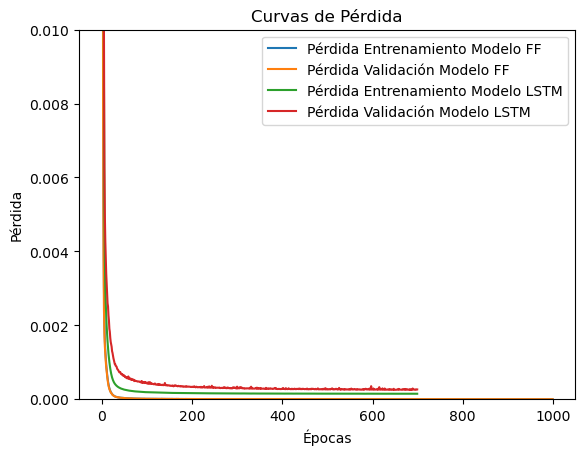

In [38]:
compare_models(FF_SS_network, LSTM_network,'Modelo FF', 'Modelo LSTM', X_test_SS, y_test_SS, X_test_LSTM, y_test_LSTM)
plot_loss_curve(FF_NN_history , 'Modelo FF', LSTM_history, 'Modelo LSTM')

# **Comparación de conjunto de Datos, Cartesiano vs Joint**

Para la comparación entre el conjunto de datos Cartesiano vs Joint, voy a crear otras redes neuronales FF y LSTM con las mismas características que las anteriores, entrenándolas exclusivamente con datasets cartesianos, y se compara la estimación de las 4 redes utilizando un nuevo conjunto joint y un nuevo conjunto cartesiano.

# Empiezo por el caso FeedForward

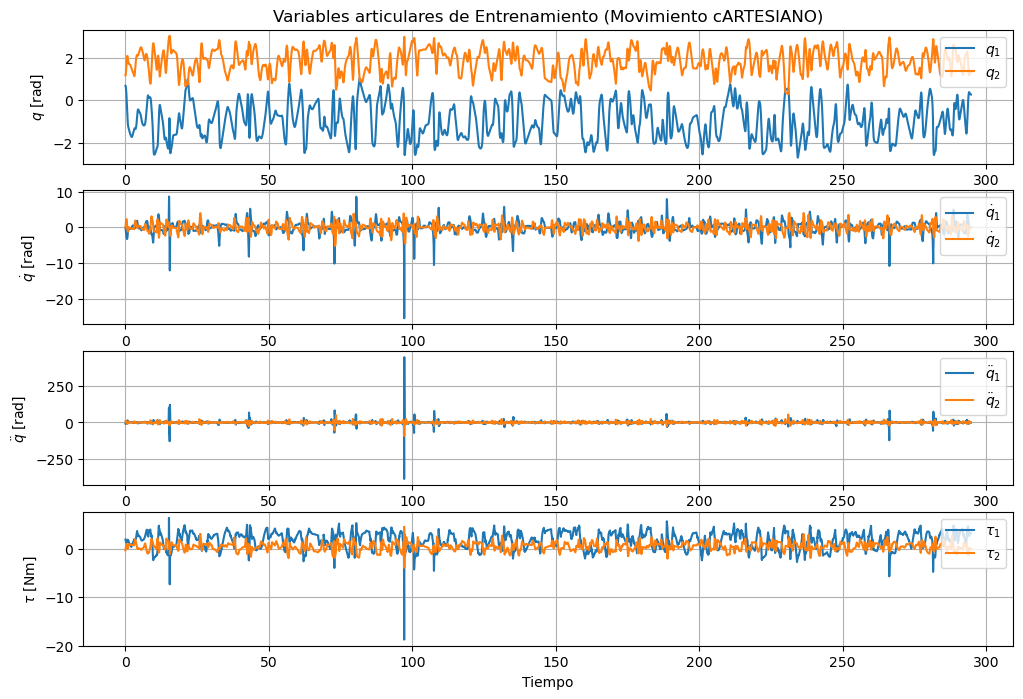

In [39]:
num_links = 2

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades
plt.subplot(4,1,1)
plt.plot(time_cart, pos_j1_cart)
plt.plot(time_cart, pos_j2_cart)
plt.legend([r'$q_1$', r'$q_2$'],loc='upper right', fontsize=10);  plt.ylabel(r"$q$ [rad]")
plt.grid(True)
plt.title('Variables articulares de Entrenamiento (Movimiento cARTESIANO)')
plt.subplot(4,1,2)
plt.plot(time_cart, vels_j1_cart)
plt.plot(time_cart, vels_j2_cart)
plt.legend([r'$\dot{q}_1$', r'$\dot{q}_2$'],loc='upper right', fontsize=10);  plt.ylabel(r"$\dot{q}$ [rad]")
plt.grid(True)
plt.subplot(4,1,3)
plt.plot(time_cart, accs_j1_cart)
plt.plot(time_cart, accs_j2_cart)
plt.legend([r'$\ddot{q}_1$', r'$\ddot{q}_2$'],loc='upper right', fontsize=10);  plt.ylabel(r"$\ddot{q}$ [rad]")
plt.grid(True)
plt.subplot(4,1,4)
plt.plot(time_cart, torq_j1_cart)
plt.plot(time_cart, torq_j2_cart)
plt.legend([r'$\tau_{1}$', r'$\tau_{2}$'],loc='upper right', fontsize=10); plt.xlabel('Tiempo'); plt.ylabel(r"$\tau$ [Nm]")
plt.grid(True)
plt.show()

In [40]:
inputs_cart = np.vstack((pos_j1_cart, pos_j2_cart, vels_j1_cart, vels_j2_cart, accs_j1_cart, accs_j2_cart)).T
outputs_cart = np.vstack((torq_j1_cart, torq_j2_cart)).T

In [41]:
#Preparo los datos para la red FF
X_train_FF_cart, X_test_FF_cart, y_train_FF_cart, y_test_FF_cart = train_test_split(inputs_cart, outputs_cart, test_size = 0.15)
X_train_FF_cart, X_val_FF_cart, y_train_FF_cart, y_val_FF_cart = train_test_split(X_train_FF_cart, y_train_FF_cart, test_size=0.15)

In [42]:
#Tengo que hacer preprocesado de los datos para que los calculos no sean tan pesados
scaler1_FF_cart = StandardScaler()
X_train_FF_cart = scaler1_FF_cart.fit_transform(X_train_FF_cart)#Primero se llama a la funcion fit para que ajuste los datos
X_test_FF_cart = scaler1_FF_cart.transform(X_test_FF_cart) #Una vez que los datos fueron ajustados se puede llamar a la transformacion directamente
X_val_FF_cart = scaler1_FF_cart.transform(X_val_FF_cart)

#Lo mismo para los outputs
scaler2_FF_cart = StandardScaler() #Otra forma de ESCALAR ---> scaler = StandardScaler()
y_train_FF_cart = scaler2_FF_cart.fit_transform(y_train_FF_cart)
y_test_FF_cart = scaler2_FF_cart.transform(y_test_FF_cart)
y_val_FF_cart = scaler2_FF_cart.transform(y_val_FF_cart)

🔄 Cargando modelo FF NN (CARTESIANO) existente...


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 100)            │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,008 (128.94 KB)

 Trainable params: 11,002 (42.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,006 (85.96 KB)

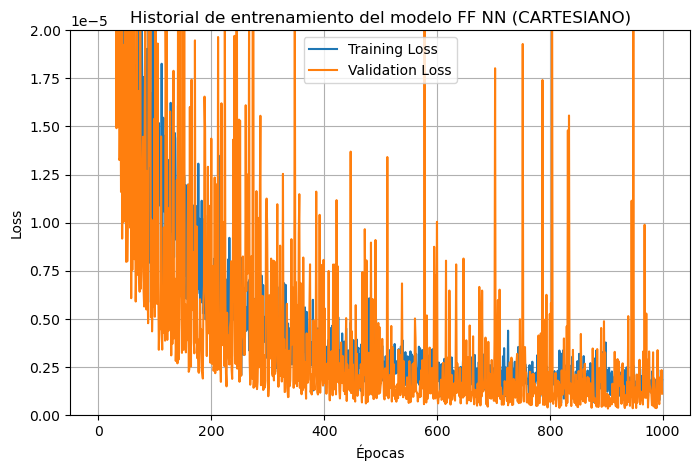

✅ Modelo FF NN (CARTESIANO) listo para usar.


In [43]:
# Verificar si el modelo ya existe

FF_NN_cart_model_path = "./2LPR/ID_NN/Modelos_NN/FF_NN_cart/ff_nn_SS_Best_Model.keras"
FF_NN_cart_history_path = "./2LPR/ID_NN/Modelos_NN/FF_NN_cart/ff_nn_SS_best_history.json"

if os.path.exists(FF_NN_cart_model_path):
    print("🔄 Cargando modelo FF NN (CARTESIANO) existente...")
    FF_NN_cart_network = keras.models.load_model(FF_NN_cart_model_path)
    FF_NN_cart_network.summary()

    if os.path.exists(FF_NN_cart_history_path):
        with open(FF_NN_cart_history_path, "r") as f:
            FF_NN_cart_history = json.load(f)
        with open(FF_NN_cart_history_path, "r") as f:
            FF_NN_cart_history = json.load(f)  # Load the history data as a dictionary

        # Create a dummy History object for plotting:
        #FF_NN_cart_history = type('DummyHistory', (object,), {'history': FF_NN_cart_history_dict})()

        # Graficar el history
        plt.figure(figsize=(8, 5))
        plt.plot(FF_NN_cart_history["loss"], label="Training Loss")
        plt.plot(FF_NN_cart_history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.gca().set_ylim(0, 2e-5)
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Historial de entrenamiento del modelo FF NN (CARTESIANO)")
        plt.show()
    else:
        print("⚠️ No se encontró el archivo de history.")
else:
    print("⚙️ Creando nuevo modelo...")
    #Esta forma es lo más parecida posible al paper
    FF_NN_cart_network = keras.models.Sequential([
        keras.layers.Dense(units=100, activation="gelu", input_shape=(inputs_cart.shape[1],)),
        keras.layers.Dense(100, activation="gelu"),
        #keras.layers.Dense(50, activation="tanh"),
        keras.layers.Dense(2)
    ])
    FF_NN_cart_network.summary()

    FF_NN_cart_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(1e-4), metrics = ['mae'])

    checkpoint_cb_cart = keras.callbacks.ModelCheckpoint(FF_NN_cart_model_path, save_best_only=True)
    early_stopping_cb_cart = keras.callbacks.EarlyStopping(patience=200, min_delta=1e-10, restore_best_weights=True)
    
    FF_NN_cart_history = FF_NN_cart_network.fit(X_train_FF_cart, y_train_FF_cart, batch_size=200, 
                                                epochs=1000, validation_data=(X_val_FF_cart, y_val_FF_cart), 
                                                callbacks=[checkpoint_cb_cart, early_stopping_cb_cart])

    with open(FF_NN_cart_history_path, "w") as f:
        json.dump(FF_NN_cart_history.history, f)
    with open(FF_NN_cart_history_path, "r") as f:
        FF_NN_cart_history = json.load(f)  # Load the history data as a dictionary

    # Create a dummy History object for plotting:
    #FF_NN_cart_history = type('DummyHistory', (object,), {'history': FF_NN_cart_history_dict})()

    pd.DataFrame(FF_NN_cart_history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 2e-5)
    plt.show()

print("✅ Modelo FF NN (CARTESIANO) listo para usar.")

# Caso LSTM

In [44]:
inputs_LSTM_cart = np.vstack((pos_j1_cart, pos_j2_cart, vels_j1_cart, vels_j2_cart, accs_j1_cart, accs_j2_cart)).T
outputs_LSTM_cart = np.vstack((torq_j1_cart, torq_j2_cart)).T

In [45]:
# Preprocesar (escalar) los inputs y outputs antes de crear las secuencias
scaler1_LSTM_cart = StandardScaler()
inputs_LSTM_cart = scaler1_LSTM_cart.fit_transform(inputs_LSTM_cart)

scaler2_LSTM_cart = StandardScaler()
outputs_LSTM_cart = scaler2_LSTM_cart.fit_transform(outputs_LSTM_cart)

X_train_LSTM_cart, y_train_LSTM_cart, X_test_LSTM_cart, y_test_LSTM_cart, t_test_LSTM_cart  = create_lstm_sequences(inputs_LSTM_cart, outputs_LSTM_cart, time_cart, window_size=w_size, split=0.8)

🔄 Cargando modelo LSTM (CARTESIANO) existente...


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 20)             │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,608 (25.82 KB)

 Trainable params: 2,202 (8.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,406 (17.21 KB)

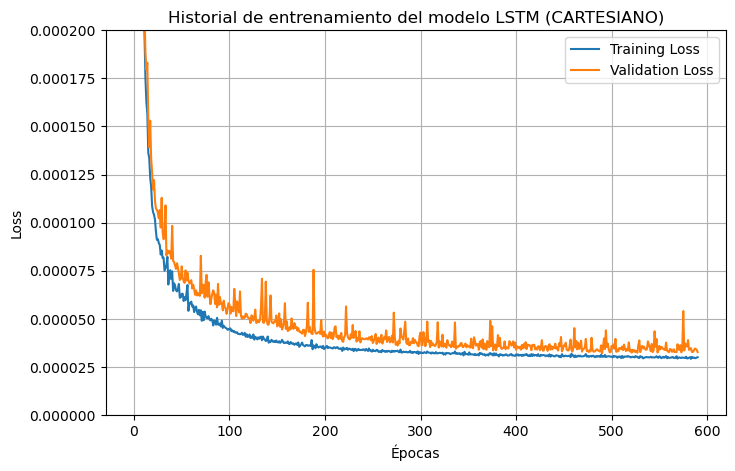

✅ Modelo LSTM (CARTESANO) listo para usar.


In [46]:
# Verificar si el modelo ya existe

LSTM_cart_model_path = "./2LPR/ID_NN/Modelos_NN/LSTM_cart/LSTM_nn_Best_Model.keras"
LSTM_cart_history_path = "./2LPR/ID_NN/Modelos_NN/LSTM_cart/lstm_best_history.json"

if os.path.exists(LSTM_cart_model_path):
    print("🔄 Cargando modelo LSTM (CARTESIANO) existente...")
    LSTM_cart_network = keras.models.load_model(LSTM_cart_model_path)
    LSTM_cart_network.summary()

    if os.path.exists(LSTM_cart_history_path):
        with open(LSTM_cart_history_path, "r") as f:
            LSTM_cart_history = json.load(f)
        with open(LSTM_cart_history_path, "r") as f:
            LSTM_cart_history = json.load(f)  # Load the history data as a dictionary
        # Create a dummy History object for plotting:
        #LSTM_cart_history = type('DummyHistory', (object,), {'history': LSTM_cart_history_dict})()

        # Graficar el history
        plt.figure(figsize=(8, 5))
        plt.plot(LSTM_cart_history["loss"], label="Training Loss")
        plt.plot(LSTM_cart_history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.xlabel("Épocas")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.gca().set_ylim(0, 2e-4)
        plt.title("Historial de entrenamiento del modelo LSTM (CARTESIANO)")
        plt.show()
    else:
        print("⚠️ No se encontró el archivo de history.")
else:
    print("⚙️ Creando nuevo modelo...")
    LSTM_cart_network = Sequential() #Sequential([Input(shape=(w_size, X_train_LSTM.shape[2]))])
    LSTM_cart_network.add(LSTM(20, activation='gelu', input_shape=(w_size, X_train_LSTM_cart.shape[2])))
    #LSTM_cart_network.add(LSTM(10, activation='tanh', dropout=0))
    LSTM_cart_network.add(Dense(y_train_LSTM_cart.shape[1]))
    LSTM_cart_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(1e-4), metrics = ['mae']) #learning_rate=1e-5
    LSTM_cart_network.summary()


    LSTM_checkpoint_cb_cart = keras.callbacks.ModelCheckpoint(LSTM_cart_model_path, save_best_only=True)
    LSTM_early_stopping_cb_cart = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, 
                                                                min_delta=1E-10, restore_best_weights=True)

    LSTM_cart_history = LSTM_cart_network.fit(X_train_LSTM_cart, y_train_LSTM_cart, epochs=700, 
                                              batch_size=64, validation_data=(X_test_LSTM_cart, y_test_LSTM_cart), 
                                              callbacks=[LSTM_checkpoint_cb_cart, LSTM_early_stopping_cb_cart])    
    
    with open(LSTM_cart_history_path, "w") as f:
        json.dump(LSTM_cart_history.history, f)
    with open(LSTM_cart_history_path, "r") as f:
        LSTM_cart_history = json.load(f)  # Load the history data as a dictionary
    # Create a dummy History object for plotting:
    #LSTM_cart_history = type('DummyHistory', (object,), {'history': LSTM_cart_history_dict})()

    pd.DataFrame(LSTM_cart_history).plot(figsize=(8, 5))
    plt.grid(True)
    #plt.gca().set_xlim(0, 1)
    plt.gca().set_ylim(0, 2e-4)
    plt.show()

print("✅ Modelo LSTM (CARTESANO) listo para usar.")

# Comparación de estimaciones

**Estimación de Dataset Joint**

In [47]:
#Estimación de Dataset Joint
#Uso el otro dataset joint

datos_2LRP_comp_joint = pd.read_csv(f'./2lpr_jointmovement_2024_12_01-18_04_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

t_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,1].values

q1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,2].values
q2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,3].values

dq1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,4].values
dq2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,5].values

ddq1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,6].values
ddq2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,7].values

t1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,8].values
t2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:,9].values
datos_2LRP_comp_joint.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.926178,-1.430799,0.001258,0.004265,1.257762,4.265447,-2.000074,-0.890958
1,2,0.001,-1.926176,-1.430793,0.002516,0.008531,1.257762,4.265447,-1.999438,-0.888827
2,3,0.002,-1.926173,-1.430782,0.003773,0.012796,1.257762,4.265447,-1.998798,-0.886697
3,4,0.003,-1.926168,-1.430767,0.005031,0.017062,1.257762,4.265447,-1.998153,-0.884568
4,5,0.004,-1.926163,-1.430748,0.006289,0.021327,1.257762,4.265447,-1.997503,-0.882441


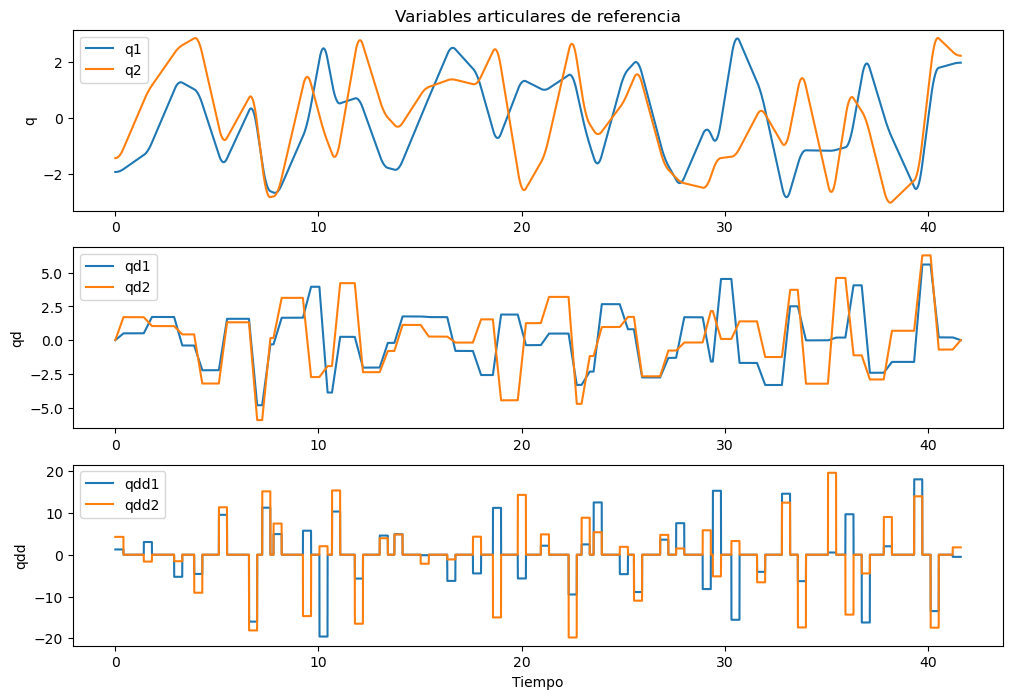

In [48]:
num_links = 2

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(t_ref_comp_joint, q1_ref_comp_joint)
plt.plot(t_ref_comp_joint, q2_ref_comp_joint)
plt.legend(['q1', 'q2']);  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref_comp_joint, dq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, dq2_ref_comp_joint)
plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref_comp_joint, ddq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, ddq2_ref_comp_joint)
plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.show()

In [49]:
inputs_ref_comp_joint = np.vstack((q1_ref_comp_joint,q2_ref_comp_joint,dq1_ref_comp_joint,dq2_ref_comp_joint,ddq1_ref_comp_joint,ddq2_ref_comp_joint)).T
outputs_ref_comp_joint = np.vstack((t1_ref_comp_joint,t2_ref_comp_joint)).T

In [50]:
#Primero con FF NN entrenada con Cartesianas
X_test_scaled_FF_NN_comp_joint_c = scaler1_FF_cart.transform(inputs_ref_comp_joint)
tau_sim_FF_NN_comp_joint_c = scaler2_FF_cart.inverse_transform(FF_NN_cart_network.predict(X_test_scaled_FF_NN_comp_joint_c))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step


In [51]:
#Primero con FF NN entrenada con Joint
X_test_scaled_FF_NN_comp_joint_j = scaler1_FF.transform(inputs_ref_comp_joint)
tau_sim_FF_NN_comp_joint_j = scaler2_FF.inverse_transform(FF_SS_network.predict(X_test_scaled_FF_NN_comp_joint_j))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step


In [52]:
#Con LSTM entrenada con Cartesianas
X_test_scaled_LSTM_comp_joint_c = scaler1_LSTM_cart.transform(inputs_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_c, t_ref_LSTM_comp_joint_c = create_sequences_with_time(X_test_scaled_LSTM_comp_joint_c, t_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_c
tau_sim_LSTM_comp_joint_c = scaler2_LSTM_cart.inverse_transform(LSTM_cart_network.predict(X_test_windowed_LSTM_comp_joint_c))
tau_sim_LSTM_comp_joint_c

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


array([[-2.7160962 , -1.6509278 ],
       [-2.7153742 , -1.6490698 ],
       [-2.7146437 , -1.6472054 ],
       ...,
       [-2.2146132 , -0.8454478 ],
       [-2.21485   , -0.8447031 ],
       [-2.215083  , -0.84395766]], dtype=float32)

In [53]:
#Con LSTM entrenada con Joint
X_test_scaled_LSTM_comp_joint_j = scaler1_LSTM.transform(inputs_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_j, t_ref_LSTM_comp_joint_j = create_sequences_with_time(X_test_scaled_LSTM_comp_joint_j, t_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_j
tau_sim_LSTM_comp_joint_j = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM_comp_joint_j))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


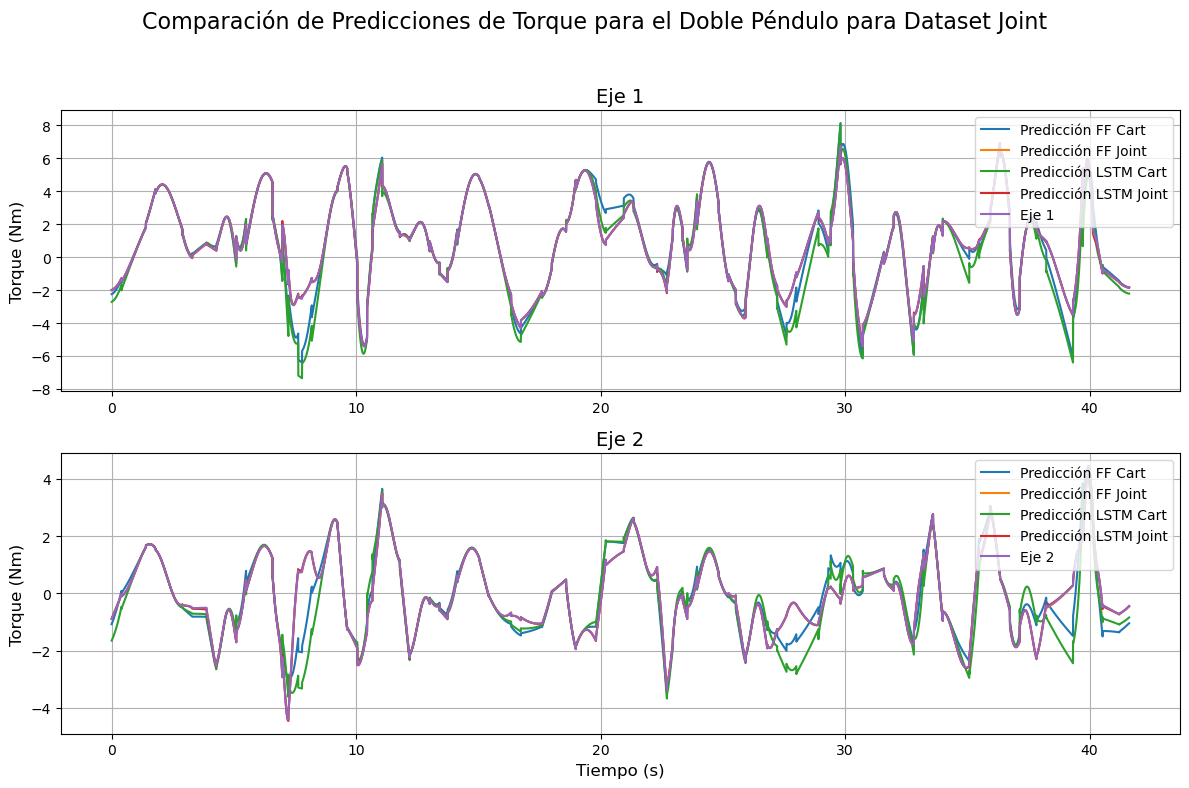

In [54]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Torque para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_joint,tau_sim_FF_NN_comp_joint_c[:,i], label='Predicción FF Cart')
    plt.plot(t_ref_comp_joint,tau_sim_FF_NN_comp_joint_j[:,i], label='Predicción FF Joint')
    plt.plot(t_ref_LSTM_comp_joint_c,tau_sim_LSTM_comp_joint_c[:,i], label='Predicción LSTM Cart')
    plt.plot(t_ref_LSTM_comp_joint_j,tau_sim_LSTM_comp_joint_j[:,i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_joint,outputs_ref_comp_joint[:,i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Torque (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()

In [55]:
w_size

2

Eje 1:
3.8672339618070697
0.11295873154858738
4.906548784609402
2.034507062825676
0.3594903177375061
0.009913626227068538
0.47207511243940226
0.014653879937905808
Eje 2:
2.8021191295914702
0.031121974124778795
4.1180144375281245
0.6239485557361566
0.29670111757328205
0.005013521572970857
0.3919022246084095
0.00838900536456324


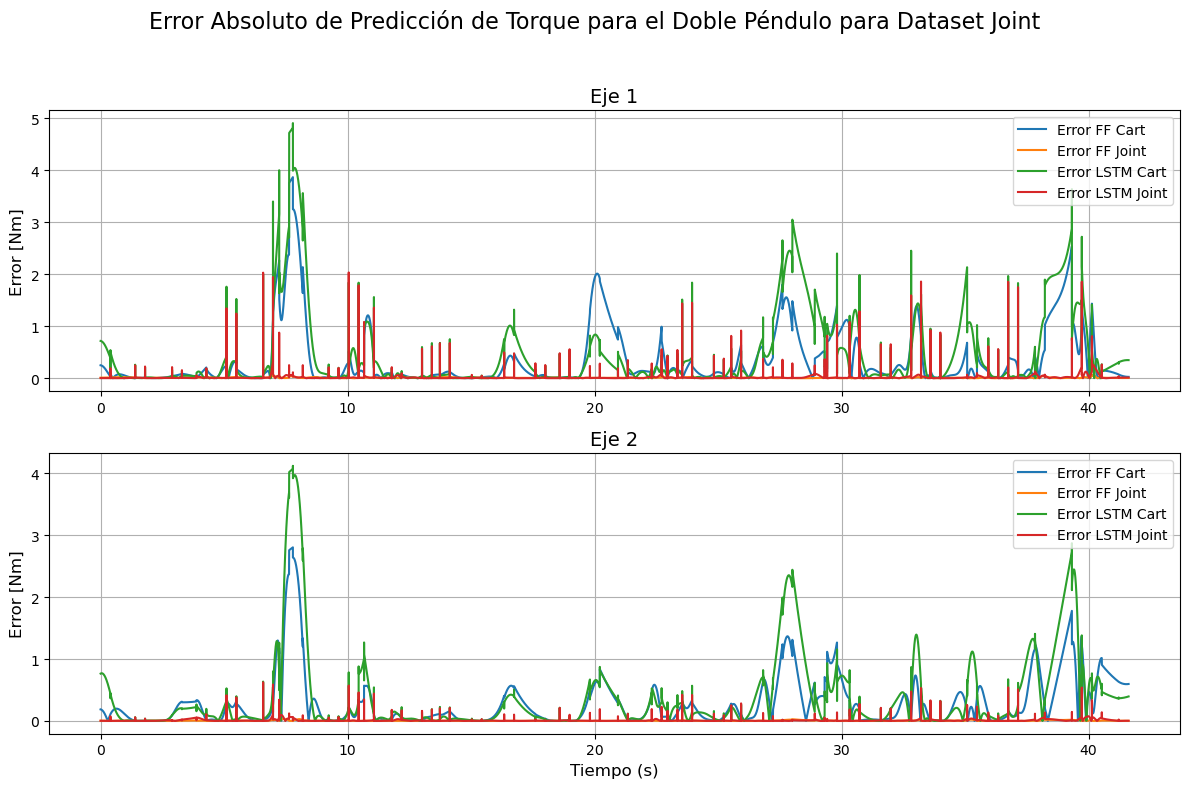

In [56]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título gen[w_size:]eral
plt.suptitle("Error Absoluto de Predicción de Torque para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Calcular errores
    error_OSA_Cart_j = np.sqrt((tau_sim_FF_NN_comp_joint_c[:, i] - outputs_ref_comp_joint[:, i])**2)
    error_OSA_Joint_j = np.sqrt((tau_sim_FF_NN_comp_joint_j[:, i] - outputs_ref_comp_joint[:, i])**2)
    error_LSTM_Cart_j = np.sqrt((tau_sim_LSTM_comp_joint_c[:-1, i] - outputs_ref_comp_joint[w_size:, i])**2)
    error_LSTM_Joint_j = np.sqrt((tau_sim_LSTM_comp_joint_j[:-1, i] - outputs_ref_comp_joint[w_size:, i])**2)
    
    print(f"Eje {i+1}:")
    print(max(error_OSA_Cart_j))
    print(max(error_OSA_Joint_j))
    print(max(error_LSTM_Cart_j))
    print(max(error_LSTM_Joint_j))
    print(np.mean(error_OSA_Cart_j))
    print(np.mean(error_OSA_Joint_j))
    print(np.mean(error_LSTM_Cart_j))
    print(np.mean(error_LSTM_Joint_j))

    # Graficar los errores
    plt.plot(t_ref_comp_joint, error_OSA_Cart_j, label='Error FF Cart')
    plt.plot(t_ref_comp_joint, error_OSA_Joint_j, label='Error FF Joint')
    plt.plot(t_ref_comp_joint[w_size:], error_LSTM_Cart_j, label='Error LSTM Cart')
    plt.plot(t_ref_comp_joint[w_size:], error_LSTM_Joint_j, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error [Nm]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


**Estimación de Dataset Cartesiano**

In [57]:
#Estimación de Dataset Cartesiano

datos_2LRP_comp_cart = pd.read_csv(f'./2lpr_cartesianmovement_2024_12_01-18_04_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

t_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,1].values

q1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,2].values
q2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,3].values

dq1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,4].values
dq2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,5].values

ddq1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,6].values
ddq2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,7].values

t1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,8].values
t2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:,9].values
datos_2LRP_comp_cart.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.174887,1.043499,-0.006224,0.011834,-4.149315,7.888932,2.095864,0.976848
1,2,0.001,-1.174893,1.043511,-0.010373,0.019723,-4.149118,7.888525,2.093779,0.980795
2,3,0.002,-1.174903,1.043531,-0.014523,0.027611,-4.148843,7.887955,2.091685,0.984743
3,4,0.003,-1.174918,1.043558,-0.018671,0.035499,-4.148489,7.887223,2.089583,0.988693
4,5,0.004,-1.174936,1.043594,-0.022820,0.043386,-4.148057,7.886328,2.087471,0.992643


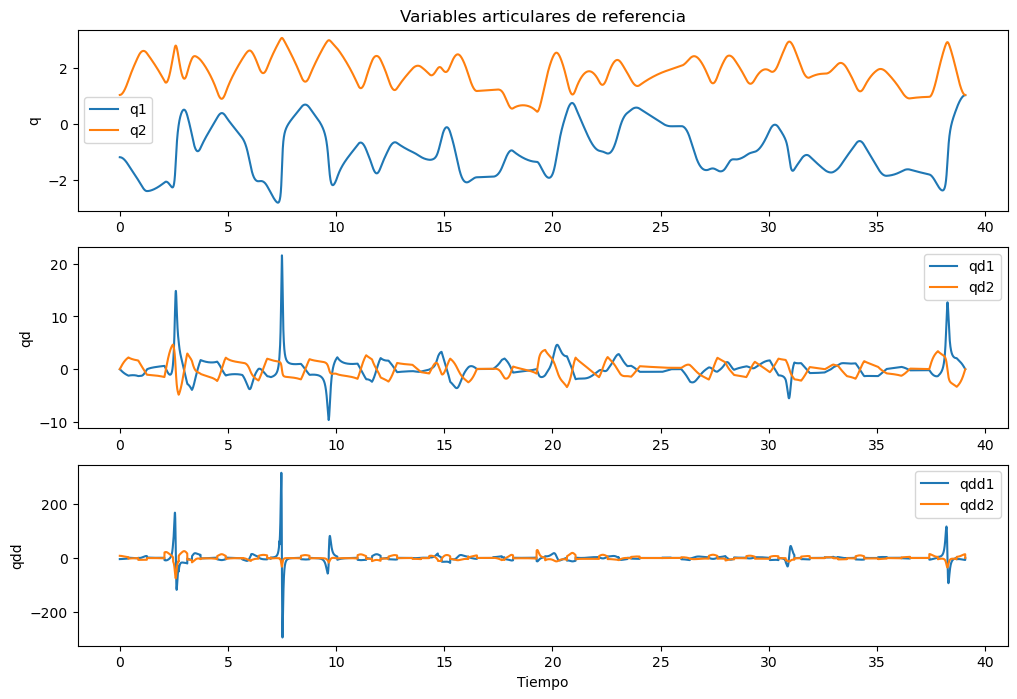

In [58]:
num_links = 2

plt.figure(figsize=(12, 8))
plt.subplot(3,1,1)
plt.plot(t_ref_comp_cart, q1_ref_comp_cart)
plt.plot(t_ref_comp_cart, q2_ref_comp_cart)
plt.legend(['q1', 'q2']);  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref_comp_cart, dq1_ref_comp_cart)
plt.plot(t_ref_comp_cart, dq2_ref_comp_cart)
plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref_comp_cart, ddq1_ref_comp_cart)
plt.plot(t_ref_comp_cart, ddq2_ref_comp_cart)
plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.show()

In [59]:
inputs_ref_comp_cart = np.vstack((q1_ref_comp_cart,q2_ref_comp_cart,dq1_ref_comp_cart,dq2_ref_comp_cart,ddq1_ref_comp_cart,ddq2_ref_comp_cart)).T
outputs_ref_comp_cart = np.vstack((t1_ref_comp_cart,t2_ref_comp_cart)).T

In [60]:
#Primero con FF NN entrenada con Cart

X_test_scaled_FF_NN_comp_cart_c = scaler1_FF_cart.transform(inputs_ref_comp_cart)
tau_sim_FF_NN_comp_cart_c = scaler2_FF_cart.inverse_transform(FF_NN_cart_network.predict(X_test_scaled_FF_NN_comp_cart_c))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [61]:
#Primero con FF NN entrenada con Joint

X_test_scaled_FF_NN_comp_cart_j = scaler1_FF.transform(inputs_ref_comp_cart)
tau_sim_FF_NN_comp_cart_j = scaler2_FF.inverse_transform(FF_SS_network.predict(X_test_scaled_FF_NN_comp_cart_j))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step


In [62]:
#Con LSTM entrenada con Cart
X_test_scaled_LSTM_comp_cart_c = scaler1_LSTM_cart.transform(inputs_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_c, t_ref_LSTM_comp_cart_c = create_sequences_with_time(X_test_scaled_LSTM_comp_cart_c, t_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_c
tau_sim_LSTM_comp_cart_c = scaler2_LSTM_cart.inverse_transform(LSTM_cart_network.predict(X_test_windowed_LSTM_comp_cart_c))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [63]:
#Con LSTM entrenada con Joint
X_test_scaled_LSTM_comp_cart_j = scaler1_LSTM.transform(inputs_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_j, t_ref_LSTM_comp_cart_j = create_sequences_with_time(X_test_scaled_LSTM_comp_cart_j, t_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_j
tau_sim_LSTM_comp_cart_j = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM_comp_cart_j))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


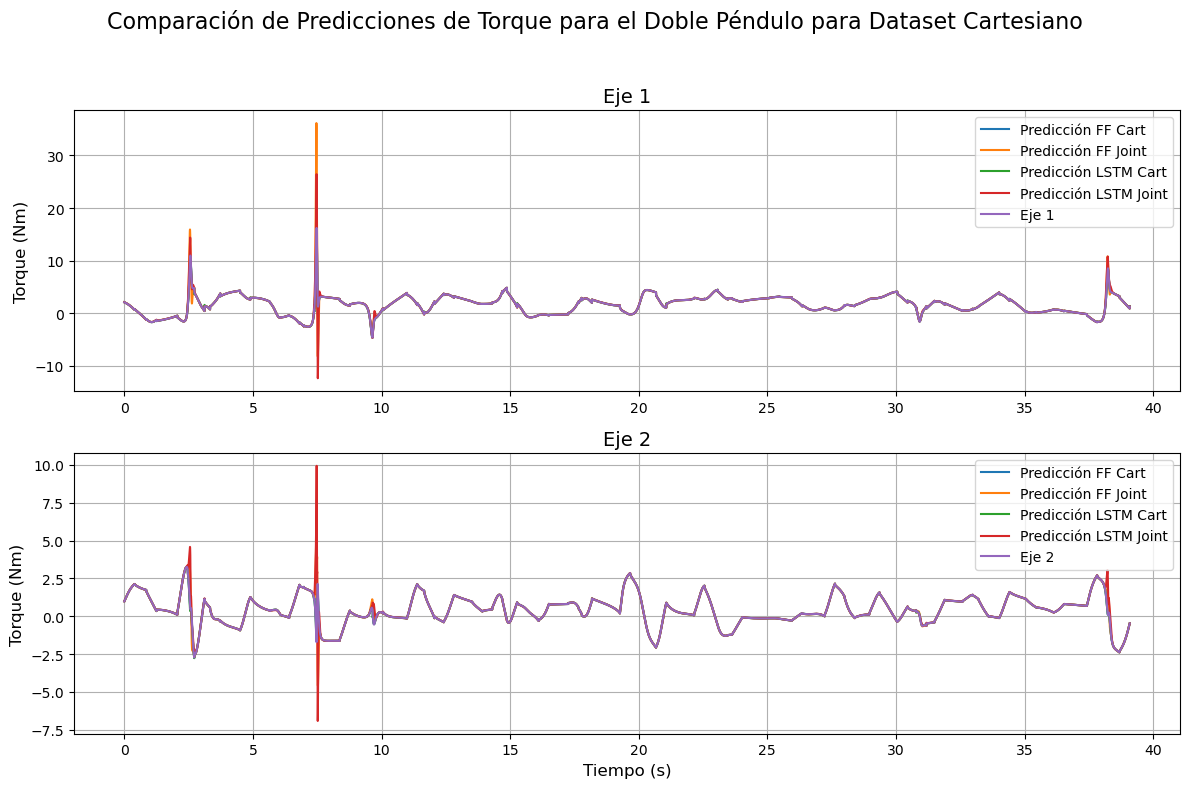

In [64]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Torque para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_cart, tau_sim_FF_NN_comp_cart_c[:, i], label='Predicción FF Cart')
    plt.plot(t_ref_comp_cart, tau_sim_FF_NN_comp_cart_j[:, i], label='Predicción FF Joint')
    plt.plot(t_ref_LSTM_comp_cart_c, tau_sim_LSTM_comp_cart_c[:, i], label='Predicción LSTM Cart')
    plt.plot(t_ref_LSTM_comp_cart_j, tau_sim_LSTM_comp_cart_j[:, i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_cart, outputs_ref_comp_cart[:, i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Torque (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


Eje 1:
1.9298270260170742
20.773120930826945
2.4840391705530216
13.93488189203762
0.01114903290546526
0.06624874733262583
0.010614116175439581
0.05526535177891436
Eje 2:
0.7651953968045664
7.132224495914718
0.7981636829220284
11.400854770304928
0.00364781704776992
0.03342216593506911
0.0030185992511053985
0.04303271990423895


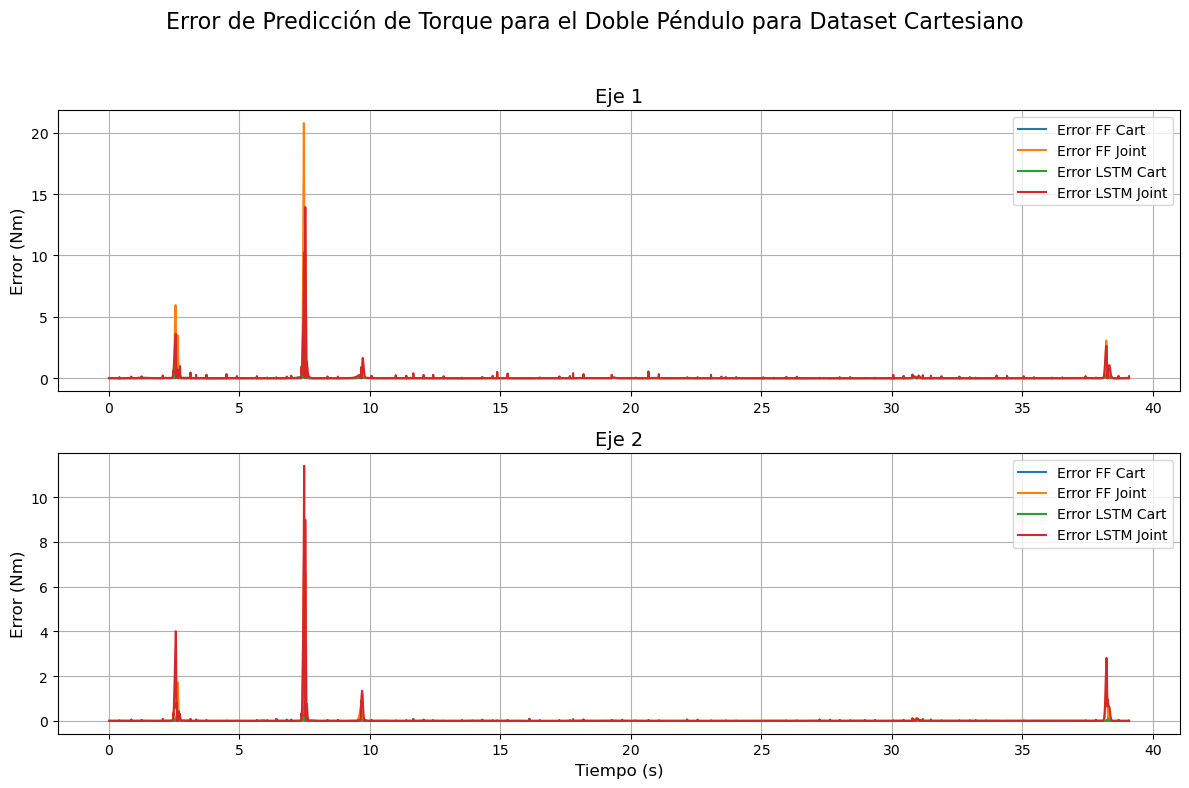

In [65]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Torque para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Calcular errores
    #error_SS_Cart_c = tau_sim_FF_NN_comp_cart_c[:, i] - outputs_ref_comp_cart[:, i]
    #error_SS_Joint_c = tau_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i]
    #error_LSTM_Cart_c = tau_sim_LSTM_comp_cart_c[:, i] - outputs_ref_comp_cart[5:, i]
    #error_LSTM_Joint_c = tau_sim_LSTM_comp_cart_j[:, i] - outputs_ref_comp_cart[5:, i]

    error_OSA_Cart_c = np.sqrt((tau_sim_FF_NN_comp_cart_c[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_OSA_Joint_c = np.sqrt((tau_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_LSTM_Cart_c = np.sqrt((tau_sim_LSTM_comp_cart_c[:-1, i] - outputs_ref_comp_cart[w_size:, i])**2)
    error_LSTM_Joint_c = np.sqrt((tau_sim_LSTM_comp_cart_j[:-1, i] - outputs_ref_comp_cart[w_size:, i])**2)

    print(f"Eje {i+1}:")
    print(max(error_OSA_Cart_c))
    print(max(error_OSA_Joint_c))
    print(max(error_LSTM_Cart_c))
    print(max(error_LSTM_Joint_c))
    print(np.mean(error_OSA_Cart_c))
    print(np.mean(error_OSA_Joint_c))
    print(np.mean(error_LSTM_Cart_c))
    print(np.mean(error_LSTM_Joint_c))

    # Graficar los errores
    plt.plot(t_ref_comp_cart, error_OSA_Cart_c, label='Error FF Cart')
    plt.plot(t_ref_comp_cart, error_OSA_Joint_c, label='Error FF Joint')
    plt.plot(t_ref_comp_cart[w_size:], error_LSTM_Cart_c, label='Error LSTM Cart')
    plt.plot(t_ref_comp_cart[w_size:], error_LSTM_Joint_c, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


# **Reentrenamiento de FF Joint con dataset cartesiano**

In [77]:
from keras.models import load_model, clone_model

# Cargar el modelo FF NN entrenado con Joint

# Ruta para guardar el nuevo modelo reentrenado
FF_NN_joint_cart_retrained_path = "./2LPR/ID_NN/Modelos_NN/FF_NN/ff_nn_joint_cart_retrained.keras"

# Clonar el modelo original para no modificarlo directamente
FF_SS_network_retrain = clone_model(FF_SS_network)
FF_SS_network_retrain.set_weights(FF_SS_network.get_weights())

# Congelar todas las capas excepto la primera capa densa (entrada)
for i, layer in enumerate(FF_SS_network_retrain.layers):
    if i != 0:  # Solo la primera capa (índice 0) será entrenable
        layer.trainable = False
    else:
        layer.trainable = True

# Compilar el modelo
FF_SS_network_retrain.compile(
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['mae']
)

# Reentrenar solo la capa de entrada con el dataset cartesiano
early_stopping_cb = keras.callbacks.EarlyStopping(patience=100, min_delta=1e-10, restore_best_weights=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint(FF_NN_joint_cart_retrained_path, save_best_only=True)

history_retrain = FF_SS_network_retrain.fit(
    X_train_FF_cart, y_train_FF_cart,
    epochs=500,
    batch_size=200,
    validation_data=(X_val_FF_cart, y_val_FF_cart),
    callbacks=[early_stopping_cb, checkpoint_cb]
)

# Guardar el modelo reentrenado
FF_SS_network_retrain.save(FF_NN_joint_cart_retrained_path)
print("✅ Modelo FF NN (Joint reentrenado solo capa de entrada con Cartesiano) guardado en:", FF_NN_joint_cart_retrained_path)

Epoch 1/500
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.7802 - mae: 0.7486 - val_loss: 0.6388 - val_mae: 0.6748
Epoch 2/500
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6111 - mae: 0.6582 - val_loss: 0.5060 - val_mae: 0.5950
Epoch 3/500
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4832 - mae: 0.5805 - val_loss: 0.4029 - val_mae: 0.5256
Epoch 4/500
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3850 - mae: 0.5130 - val_loss: 0.3203 - val_mae: 0.4643
Epoch 5/500
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3067 - mae: 0.4536 - val_loss: 0.2535 - val_mae: 0.4087
Epoch 6/500
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2415 - mae: 0.3984 - val_loss: 0.1994 - val_mae: 0.3589
Epoch 7/500
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1896 - mae: 0.3502 - val_loss: 0.1562 - val_mae: 0.3154
Epoch 8/500
1065/1065 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1484 - mae: 0.3075 - val_loss: 0.1219 - val_mae: 0.2776
Epoch 9/500
1065/1065 ━━━━━━━━━━

In [78]:
inputs_ref_comp_cart = np.vstack((q1_ref_comp_cart,q2_ref_comp_cart,dq1_ref_comp_cart,dq2_ref_comp_cart,ddq1_ref_comp_cart,ddq2_ref_comp_cart)).T
outputs_ref_comp_cart = np.vstack((t1_ref_comp_cart,t2_ref_comp_cart)).T

In [79]:
X_test_scaled_FF_ret_comp_cart_j = scaler1_FF.transform(inputs_ref_comp_cart)
tau_sim_FF_ret_comp_cart_j = scaler2_FF.inverse_transform(FF_SS_network_retrain.predict(X_test_scaled_FF_ret_comp_cart_j))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


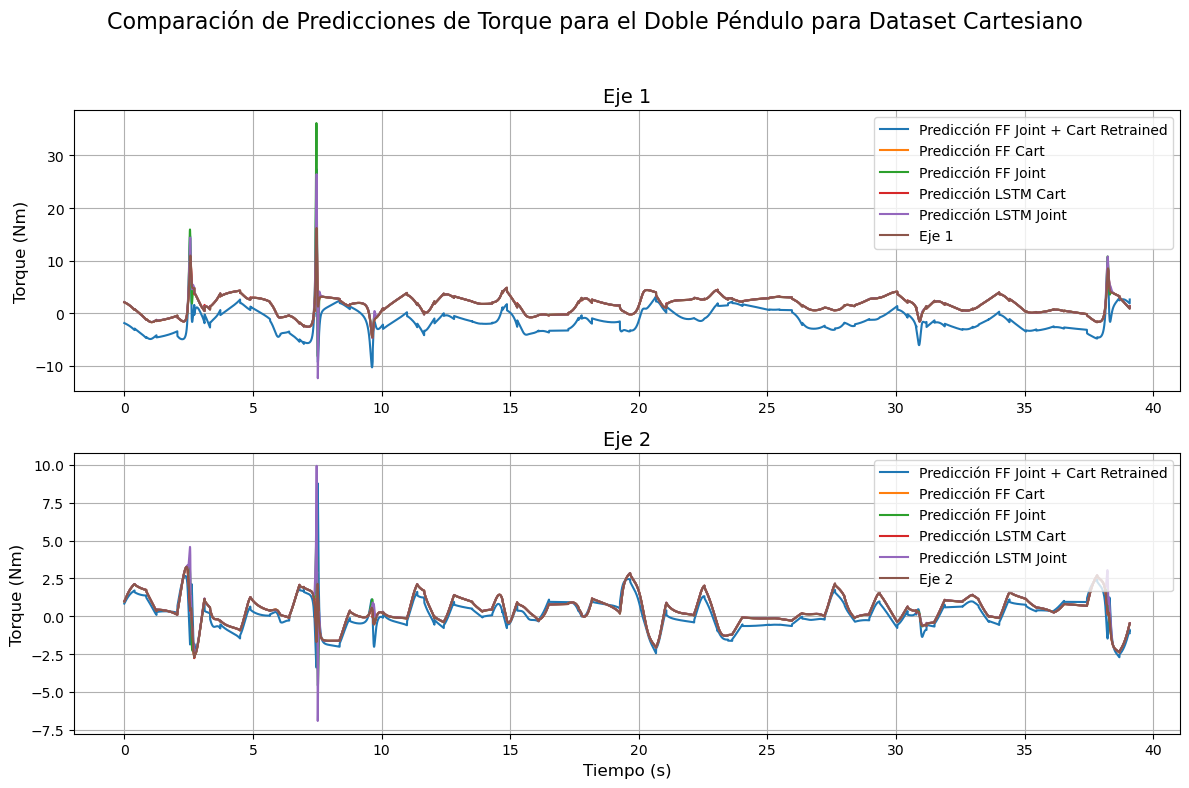

In [80]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Torque para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_cart, tau_sim_FF_ret_comp_cart_j[:, i], label='Predicción FF Joint + Cart Retrained')
    plt.plot(t_ref_comp_cart, tau_sim_FF_NN_comp_cart_c[:, i], label='Predicción FF Cart')
    plt.plot(t_ref_comp_cart, tau_sim_FF_NN_comp_cart_j[:, i], label='Predicción FF Joint')
    plt.plot(t_ref_LSTM_comp_cart_c, tau_sim_LSTM_comp_cart_c[:, i], label='Predicción LSTM Cart')
    plt.plot(t_ref_LSTM_comp_cart_j, tau_sim_LSTM_comp_cart_j[:, i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_cart, outputs_ref_comp_cart[:, i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Torque (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


Eje 1:
20.773120930826945
0.06624874733262583
Eje 2:
7.132224495914718
0.03342216593506911


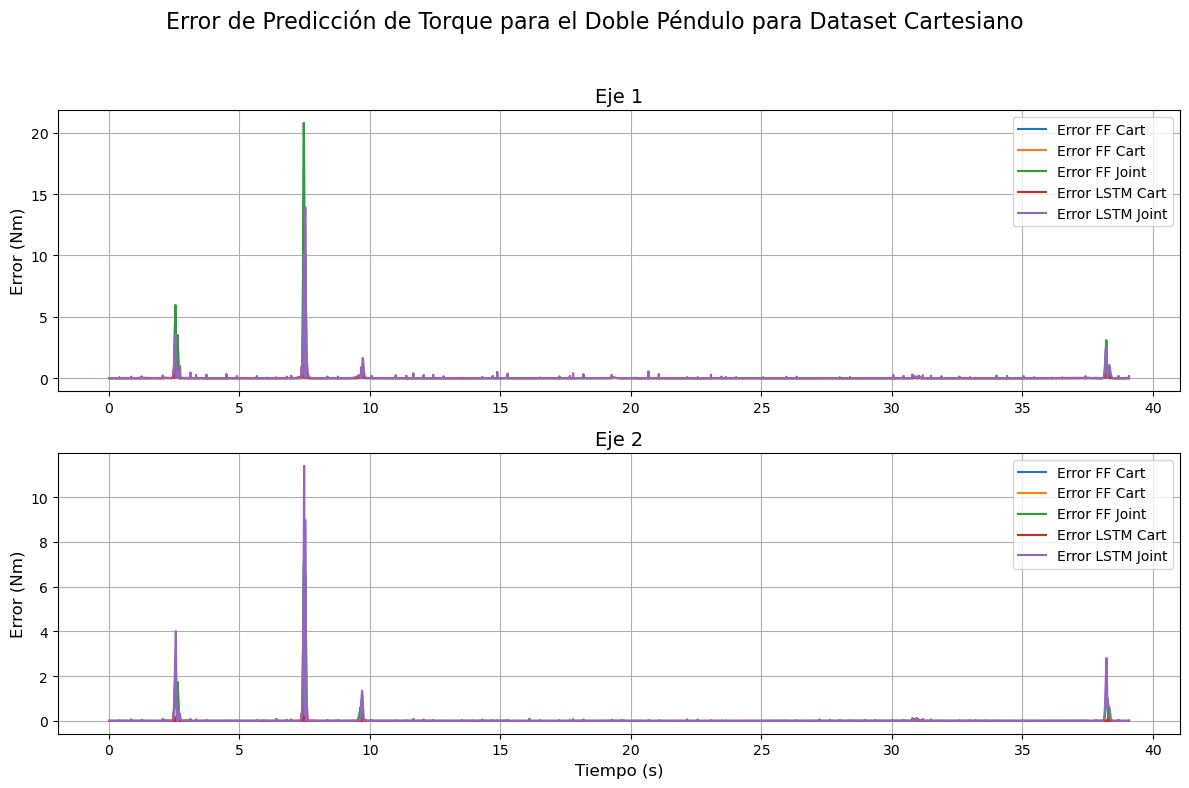

In [81]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Torque para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Calcular errores
    #error_SS_Cart_c = tau_sim_FF_NN_comp_cart_c[:, i] - outputs_ref_comp_cart[:, i]
    #error_SS_Joint_c = tau_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i]
    #error_LSTM_Cart_c = tau_sim_LSTM_comp_cart_c[:, i] - outputs_ref_comp_cart[5:, i]
    #error_LSTM_Joint_c = tau_sim_LSTM_comp_cart_j[:, i] - outputs_ref_comp_cart[5:, i]

    error_OSA_Cart_c = np.sqrt((tau_sim_FF_NN_comp_cart_c[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_OSA_Joint_c = np.sqrt((tau_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_OSA_ret = np.sqrt((tau_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_LSTM_Cart_c = np.sqrt((tau_sim_LSTM_comp_cart_c[:-1, i] - outputs_ref_comp_cart[w_size:, i])**2)
    error_LSTM_Joint_c = np.sqrt((tau_sim_LSTM_comp_cart_j[:-1, i] - outputs_ref_comp_cart[w_size:, i])**2)

    print(f"Eje {i+1}:")
    print(max(error_OSA_ret))
    print(np.mean(error_OSA_ret))

    # Graficar los errores
    plt.plot(t_ref_comp_cart, error_OSA_ret, label='Error FF Cart')
    plt.plot(t_ref_comp_cart, error_OSA_Cart_c, label='Error FF Cart')
    plt.plot(t_ref_comp_cart, error_OSA_Joint_c, label='Error FF Joint')
    plt.plot(t_ref_comp_cart[w_size:], error_LSTM_Cart_c, label='Error LSTM Cart')
    plt.plot(t_ref_comp_cart[w_size:], error_LSTM_Joint_c, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


In [82]:
inputs_ref_comp_joint = np.vstack((q1_ref_comp_joint,q2_ref_comp_joint,dq1_ref_comp_joint,dq2_ref_comp_joint,ddq1_ref_comp_joint,ddq2_ref_comp_joint)).T
outputs_ref_comp_joint = np.vstack((t1_ref_comp_joint,t2_ref_comp_joint)).T

In [83]:
X_test_scaled_FF_ret= scaler1_FF.transform(inputs_ref_comp_joint)
tau_sim_FF_ret = scaler2_FF.inverse_transform(FF_SS_network_retrain.predict(X_test_scaled_FF_ret))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


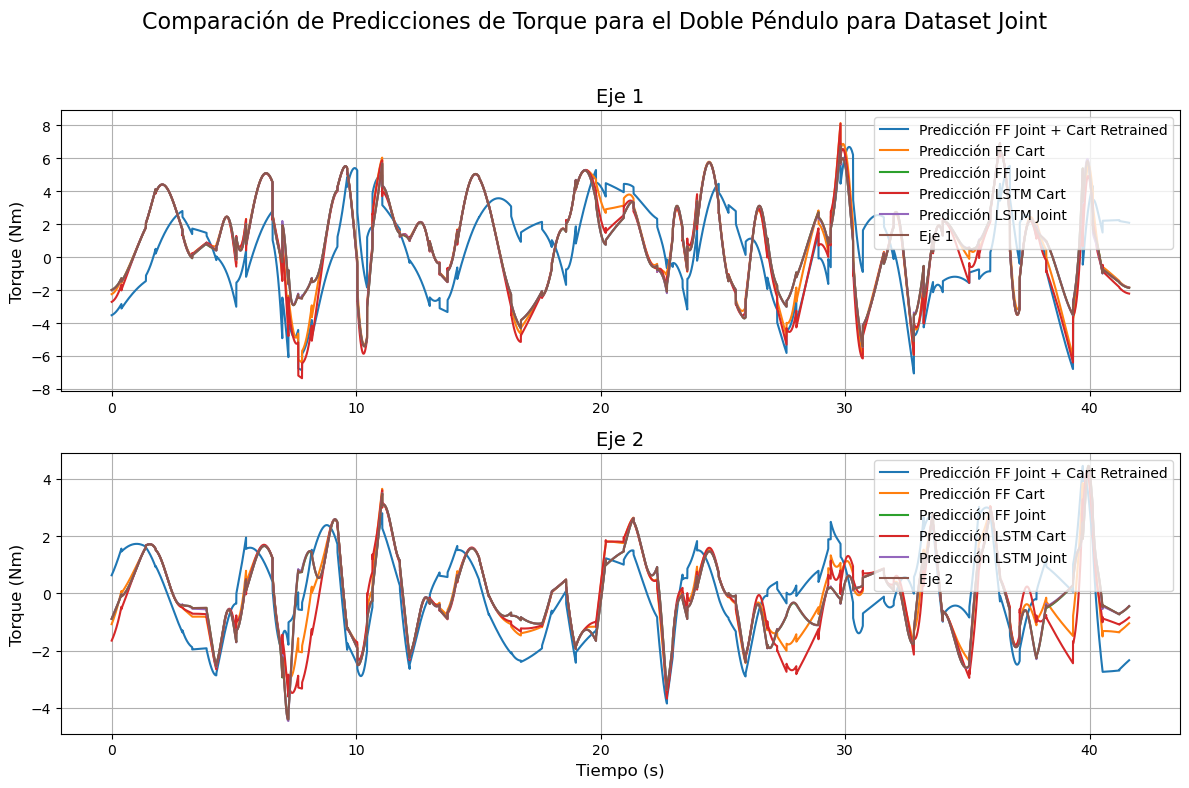

In [84]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Torque para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_joint, tau_sim_FF_ret[:, i], label='Predicción FF Joint + Cart Retrained')
    plt.plot(t_ref_comp_joint,tau_sim_FF_NN_comp_joint_c[:,i], label='Predicción FF Cart')
    plt.plot(t_ref_comp_joint,tau_sim_FF_NN_comp_joint_j[:,i], label='Predicción FF Joint')
    plt.plot(t_ref_LSTM_comp_joint_c,tau_sim_LSTM_comp_joint_c[:,i], label='Predicción LSTM Cart')
    plt.plot(t_ref_LSTM_comp_joint_j,tau_sim_LSTM_comp_joint_j[:,i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_joint,outputs_ref_comp_joint[:,i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Torque (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()

Eje 1:
3.8672339618070697
0.11295873154858738
4.906548784609402
2.034507062825676
0.3594903177375061
0.009913626227068538
0.47207511243940226
0.014653879937905808
Eje 2:
2.8021191295914702
0.031121974124778795
4.1180144375281245
0.6239485557361566
0.29670111757328205
0.005013521572970857
0.3919022246084095
0.00838900536456324


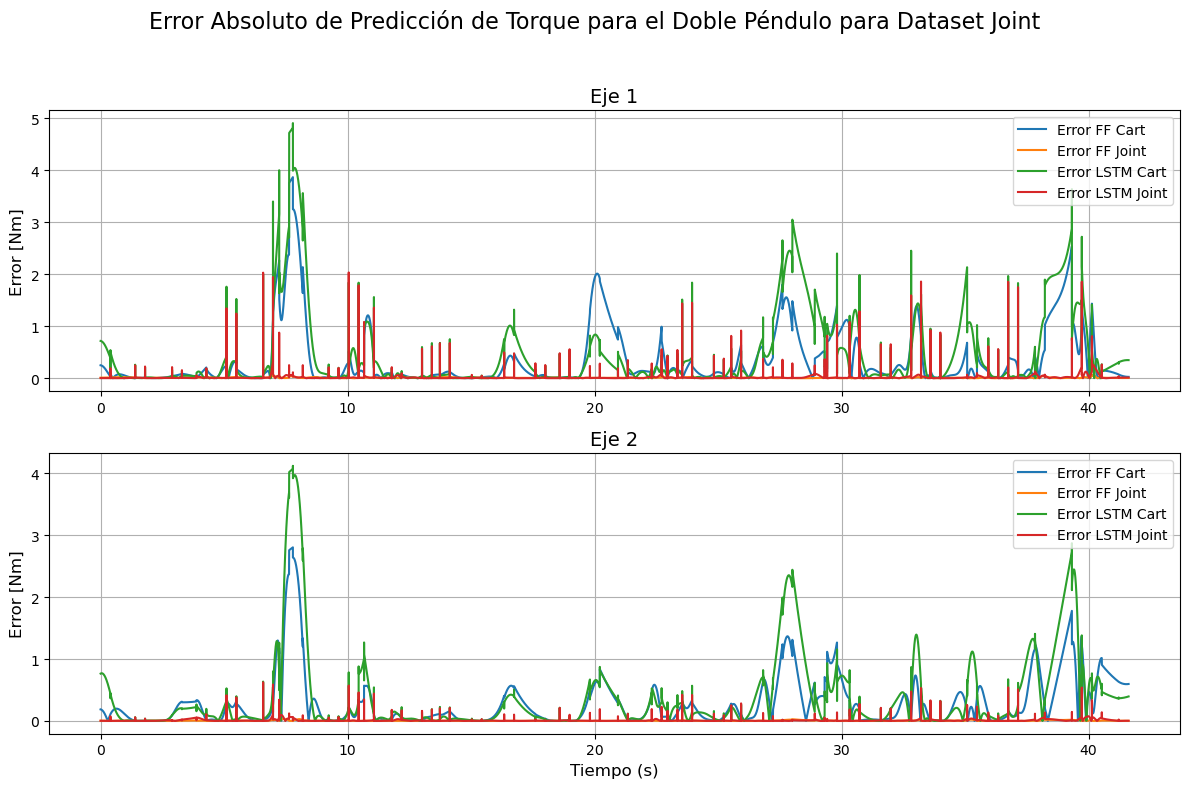

In [85]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título gen[w_size:]eral
plt.suptitle("Error Absoluto de Predicción de Torque para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Calcular errores
    error_OSA_Cart_j = np.sqrt((tau_sim_FF_NN_comp_joint_c[:, i] - outputs_ref_comp_joint[:, i])**2)
    error_OSA_Joint_j = np.sqrt((tau_sim_FF_NN_comp_joint_j[:, i] - outputs_ref_comp_joint[:, i])**2)
    error_LSTM_Cart_j = np.sqrt((tau_sim_LSTM_comp_joint_c[:-1, i] - outputs_ref_comp_joint[w_size:, i])**2)
    error_LSTM_Joint_j = np.sqrt((tau_sim_LSTM_comp_joint_j[:-1, i] - outputs_ref_comp_joint[w_size:, i])**2)
    
    print(f"Eje {i+1}:")
    print(max(error_OSA_Cart_j))
    print(max(error_OSA_Joint_j))
    print(max(error_LSTM_Cart_j))
    print(max(error_LSTM_Joint_j))
    print(np.mean(error_OSA_Cart_j))
    print(np.mean(error_OSA_Joint_j))
    print(np.mean(error_LSTM_Cart_j))
    print(np.mean(error_LSTM_Joint_j))

    # Graficar los errores
    plt.plot(t_ref_comp_joint, error_OSA_Cart_j, label='Error FF Cart')
    plt.plot(t_ref_comp_joint, error_OSA_Joint_j, label='Error FF Joint')
    plt.plot(t_ref_comp_joint[w_size:], error_LSTM_Cart_j, label='Error LSTM Cart')
    plt.plot(t_ref_comp_joint[w_size:], error_LSTM_Joint_j, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error [Nm]', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()
